<a href="https://colab.research.google.com/github/kulkarnisatishp/genai-course/blob/main/Agentic_Rag_Satish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import userdata
api_key = userdata.get('openai_key')

In [3]:
!pip install -q langchain-community langchain-openai unstructured faiss-cpu langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━

In [4]:
%cd /content/drive/MyDrive/GenAI/RAG/Agentic RAG

/content/drive/MyDrive/GenAI/RAG/Agentic RAG


In [5]:
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

from typing import List
from typing_extensions import TypedDict
from IPython.display import Markdown, display, Image

from langgraph.graph import StateGraph, END



In [6]:
file = 'dim sum montijo.xlsx'
loader = UnstructuredExcelLoader(file, mode = "elements")
data = loader.load()

embeddings = OpenAIEmbeddings(openai_api_key=api_key)
db_faiss = FAISS.from_documents(data, embeddings)

In [7]:
class AgentState(TypedDict):
  start: bool
  conversation: int
  question: str
  answer: str
  topic: bool
  documents: list
  recursion_limit: int
  memory: list

In [8]:
def greetings(state):
  print("Hello! Welcome to the restaurant. I will be your waiter. How can I help you?")
  user_input = input()
  state['start'] = True
  state['conversation'] = 1
  state['question'] = user_input
  state['memory'] = [user_input]
  return state

In [9]:
def check_question(state):

  question = state['question']
  docs = db_faiss.similarity_search(question)
  system_prompt = """
  You are a grader evaluating the appropriateness of the a customer's question to a waiter or waitress in a restaurant.
  Asses if the question is suitable to as the restaurant staff and if the customer shows interest in continuing the conversation.
  Respond with "True" if the question is appropriate for the staff or indicates the customer is asking a question or giving you information.
  Otherwise respond with "False".
  Provide only "True" or "False" in your response.
  """
  TEMPLATE  = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", "User Question: {question}"),
  ])
  prompt = TEMPLATE.format(question=question)
  model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)
  response_text = model.invoke(prompt)
  state['topic'] = response_text.content
  return state

In [10]:
def topic_router(state):
  topic = state['topic']
  if topic == "True":
    return "on_topic"
  else:
    return "off_topic"

def off_topic_response(state):
  if state['conversation'] <=1:
    state['answer'] = "\n I apologize, I can't answer that question. I can only answer questions about the menu in this restaurant."
    print(state['answer'])
  else:
    state['answer'] = "\n Happy to help."
    print(state['answer'])

In [11]:
def retrieve_docs(state):
  memory = ", ".join(state['memory'])
  docs_faiss = db_faiss.similarity_search(str(memory), k = 5)
  state['documents'] = [doc.page_content for doc in docs_faiss]

  return state

In [18]:
from re import TEMPLATE
def generate(state):
  model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)
  question = state['question']
  documents = state['documents']
  memory = state['memory']

  system_prompt = """
    You are a waiter at a restaurant tasked with answering customer's questions about the menu.
    Answer the question in the manner of a waiter, avoiding being too verbose or too brief.
    Do not include "waiter" or refer to yourself explicitly in your answer.
    """
      # Create a prompt template for formatting
  TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Context: {documents}\nConversation history so far: {memory}\nCustomer question: {question}"),
    ])

    # Format the prompt with the retrieved documents, conversation history, and customer's question
  prompt = TEMPLATE.format(documents=documents, memory=memory, question=question)

    # Invoke the model to generate an answer
  response_text = model.invoke(prompt)

    # Store the generated answer in the state
  state["answer"] = response_text.content.strip()

  return state

In [25]:
def improve_answer(state):
    # Extract necessary information from the state
    question = state['question']
    answer = state['answer']
    memory = state['memory']

    # Define the system prompt for refining the answer
    system = """
    As a waiter, review and refine the response to a customer's question. Your task is to:

    1. Ensure the answer is appropriate, friendly, and informative.
    2. Edit or remove parts of the answer as needed, without adding new information.
    3. Maintain a polite, professional, and attentive tone.
    4. Provide only the improved answer, without any introductory phrases or commentary.
    5. Conclude the response with an open-ended question to invite further inquiries or address additional needs.
    6. Consider the conversation history to be more informative and useful.
    7. Include line breaks (`\n`) at the end of each sentence or logical break.

    Deliver a refined response that enhances the customer's experience and reflects the restaurant's commitment to customer service.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Customer question: {question}\nConversation history: {memory}\nWaiter's initial answer: {answer}"),
    ])

    # Initialize the language model
    model = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

    # Format the prompt with the necessary information
    prompt = TEMPLATE.format(question=question, memory=memory, answer=answer)

    # Invoke the model to improve the answer
    response_text = model.invoke(prompt)

    # Update the state with the improved answer
    state['answer'] = response_text.content.strip()

    # Display the improved answer
    print('\n')
    print(state['answer'])

    # Append the improved answer to the conversation history
    state['memory'].append(state['answer'])

    return state

In [28]:
def further_question(state):
  print('\n')
  user_input = input()
  state['question'] = user_input
  state['memory'].append(user_input)
  state['conversation'] += 1
  return state

In [29]:
workflow = StateGraph(AgentState)
workflow.add_node("greetings",greetings)
workflow.add_node("check_question",check_question)
workflow.add_node("off_topic_response",off_topic_response)
workflow.add_node("retrieve_docs",retrieve_docs)
workflow.add_node("generate",generate)
workflow.add_node("improve_answer",improve_answer)
workflow.add_node("further_question",further_question)



workflow.set_entry_point("greetings")

workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response"
    }

)

workflow.add_edge("greetings","check_question")
workflow.add_edge("retrieve_docs","generate")
workflow.add_edge("off_topic_response", END)
workflow.add_edge("generate","improve_answer")
workflow.add_edge("improve_answer", "further_question")
workflow.add_edge("further_question", "check_question")
app = workflow.compile()

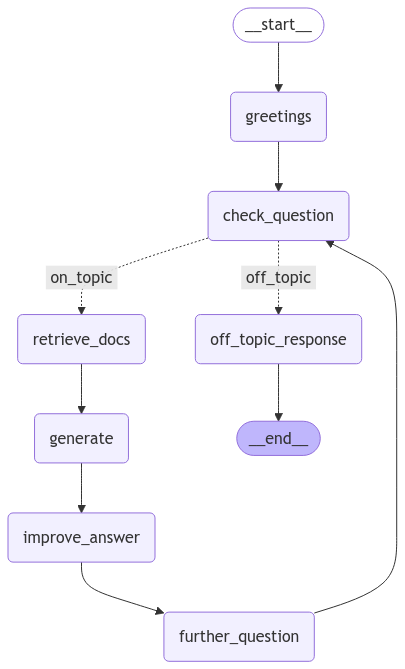

In [30]:
display(Image(app.get_graph(xray = True).draw_mermaid_png()))

In [32]:
result = app.invoke({"start":True},{"recursion_limit":50})
print(result['answer'])

Hello! Welcome to the restaurant. I will be your waiter. How can I help you?
What is your reco?


I recommend trying the Siao Long Pao, especially the Traditional version with pork, paksoy, and shiitake mushroom.  

It's a delightful dish with a wonderful balance of flavors.  

If you're in the mood for something crispy, the Gyoza, particularly the shrimp or duck options, are also fantastic choices.  

Pairing either with a refreshing cold tea will enhance your dining experience!  

Is there a specific type of dish you're in the mood for, or any dietary preferences I should consider?


suggestion for pairing?


I recommend pairing the Siao Long Pao with a glass of our Lello White or Red wine, as the wine's acidity beautifully complements the rich flavors of the dumplings.  

If you prefer non-alcoholic options, our Cold Teas, such as the Mint & Pineapple or Green Tea with Ginger and Lemon, also pair wonderfully and add a refreshing touch to your meal.  

Is there anything else you woul